### ***Dimensionality reduction***

#### ***1 PCA***

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [7]:
#load data
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"

df_gex = pd.read_csv(DATA_DIR / "mammacarcinoma_gex.csv")
df_pat = pd.read_csv(DATA_DIR / "mammacarcinoma_pat.csv")

In [27]:
#scale data
X = df_gex.drop(columns="patient_id").values #.values weil Numpyarray

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

Since PCA is depending on the variance, scaling is required to use PCA. 

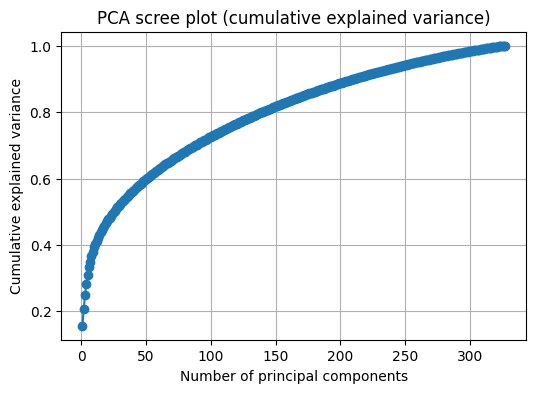

In [91]:
#scree plot
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(6, 4))
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    marker="o"
)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA scree plot (cumulative explained variance)")
plt.grid(True)
plt.savefig(
    PROJECT_ROOT / "results" / "Scree.jpeg",
    dpi=600,
    bbox_inches="tight"
)

plt.show()


In [29]:
#determine PC by variance change
for k in [2,3,4,5,6,7,8,9,10]:
    print(f"{k} PCs explain {np.sum(explained_variance[:k]):.2f} of variance")


2 PCs explain 0.21 of variance
3 PCs explain 0.25 of variance
4 PCs explain 0.28 of variance
5 PCs explain 0.31 of variance
6 PCs explain 0.33 of variance
7 PCs explain 0.35 of variance
8 PCs explain 0.37 of variance
9 PCs explain 0.38 of variance
10 PCs explain 0.39 of variance


Visually, maybe about 5 principal components (PC) inherit a relevant ammount of the variance. Which would lead to the decision to use 5 principal components. 
To verify this assumption, a investigation is performed on exemplary for 10 possible PCs. While for the first numbers, the variance per PC is 0.03 or greater, after 5 PCs this variance-share drops to 0.02, with this decreasing share of variance it is decided to limit the PCs to 5. 

In [30]:
pca_5 = PCA(n_components=5)
X_pca_5 = pca_5.fit_transform(X_scaled)


In [31]:
pca_5.explained_variance_ratio_


array([0.15683466, 0.0489869 , 0.04359563, 0.03404933, 0.02527803])

In [32]:
pca_5.explained_variance_ratio_.sum()


np.float64(0.30874455059837913)

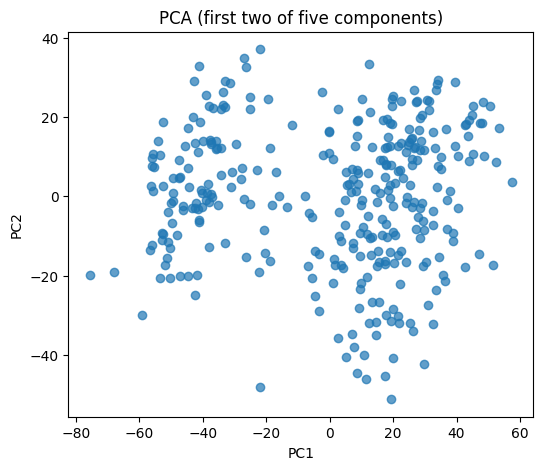

In [33]:
#plt PCA
plt.figure(figsize=(6, 5))
plt.scatter(
    X_pca_5[:, 0],
    X_pca_5[:, 1],
    alpha=0.7
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (first two of five components)")
plt.show()


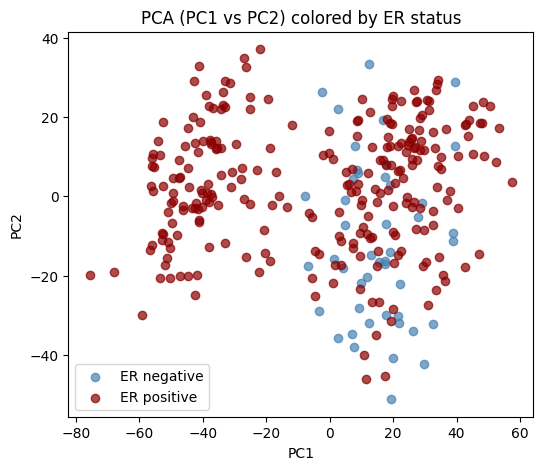

In [34]:
#color ER status in PCA
er_status = df_pat["er"]

plt.figure(figsize=(6, 5))

plt.scatter(
    X_pca_5[er_status == 0, 0],
    X_pca_5[er_status == 0, 1],
    color="steelblue",
    alpha=0.7,
    label="ER negative"
)

plt.scatter(
    X_pca_5[er_status == 1, 0],
    X_pca_5[er_status == 1, 1],
    color="darkred",
    alpha=0.7,
    label="ER positive"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA (PC1 vs PC2) colored by ER status")
plt.legend()
plt.show()


In [35]:
pc1 = X_pca[:, 0]

print("PC1 variance (ER negative):", np.var(pc1[er_status == 0]))
print("PC1 variance (ER positive):", np.var(pc1[er_status == 1]))


PC1 variance (ER negative): 140.29530297452692
PC1 variance (ER positive): 1114.056774870856


No clear separation, but it is cleary visible that ER positive carcinoma is represented more in PC1, which is underlined by the variance. Its not a clear separation, but PC1 is more associated with ER+.

To understand which genes each PC represents in which ammount, the loading is also analysed bellow.

In [36]:
# create loading table for PCA, not required for any later step. 
loadings = pd.DataFrame(
    pca_5.components_.T,
    columns=[f"PC{i+1}" for i in range(5)],
    index=df_gex.drop(columns="patient_id").columns
)

def top_loadings(loadings, pc, n=5):
    top_pos = loadings[pc].sort_values(ascending=False).head(n)
    top_neg = loadings[pc].sort_values(ascending=True).head(n)
    return pd.concat([top_pos, top_neg])

pc_loadings_summary = pd.concat(
    {
        "PC1": top_loadings(loadings, "PC1"),
        "PC2": top_loadings(loadings, "PC2"),
        "PC3": top_loadings(loadings, "PC3")
    }
).reset_index()

pc_loadings_summary.columns = ["PC", "Gene", "Loading"]
pc_loadings_summary


,PC,Gene,Loading
0,PC1,KIAA0841,0.028803
1,PC1,ADRBK1,0.027931
2,PC1,EPOR,0.027921
3,PC1,AGPAT1,0.027864
4,PC1,PRSS7,0.027548
5,PC1,EIF2S2,-0.026864
6,PC1,LSM3,-0.026684
7,PC1,HAT1,-0.026432
8,PC1,PSMA5,-0.025336
9,PC1,RPS15A,-0.025216


#### ***2 UMAP***

Umap is used in high dimensionality data, ...

In [37]:
import umap

C:\PAML\PAML Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
X_umap_input = X_scaled

Also scaled, just as the data for PCA, which leads to compareability.

In [50]:
#calculate umap
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = umap_model.fit_transform(X_umap_input)


C:\PAML\PAML Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Random with 42, as required. 
    used moderate standard values.
    n_neigbors determines the range of the radii drawn arround each datapoint
    min_dist changes the distance between the dataoint in the already lower dimensional graph. The math is already done, its the display in the plot min_dist is about

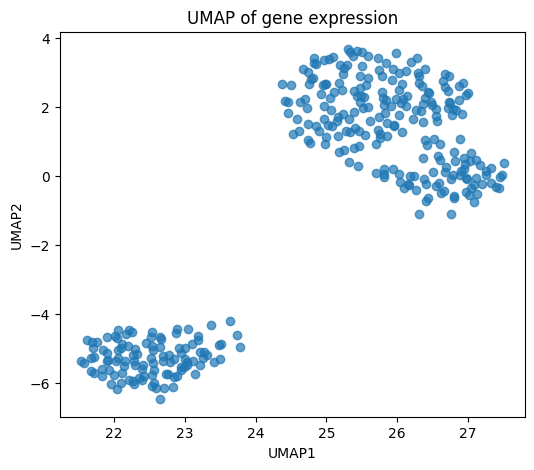

In [51]:
#plot umap, one color
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    alpha=0.7
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP of gene expression")
plt.show()


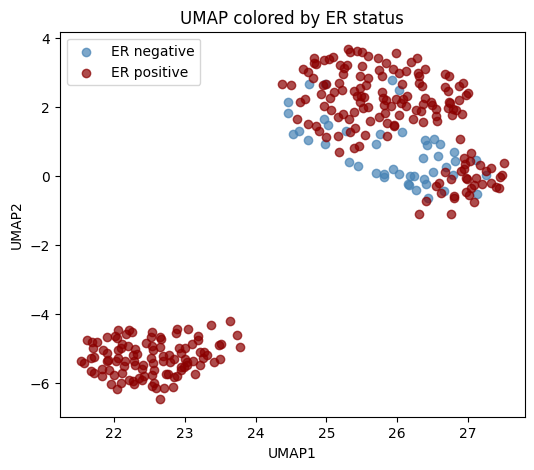

In [103]:
#color umap after ER status
er_status = df_pat["er"]

plt.figure(figsize=(6, 5))

plt.scatter(
    X_umap[er_status == 0, 0],
    X_umap[er_status == 0, 1],
    color="steelblue",
    alpha=0.7,
    label="ER negative"
)

plt.scatter(
    X_umap[er_status == 1, 0],
    X_umap[er_status == 1, 1],
    color="darkred",
    alpha=0.7,
    label="ER positive"
)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP colored by ER status")
plt.legend()
plt.show()


As expected, UMAP creates more neighboring groups. The sole depiction cannot and must not be compared to PCA. PCA is a linear technique, while 
UMAP is a non-linear technique. The origin of the visible groups is just the strenght of UMAP. 

In [104]:
umap1 = X_umap[:, 0]

print("UMAP1 variance (ER negative):", np.var(umap1[er_status == 0]))
print("UMAP1 variance (ER positive):", np.var(umap1[er_status == 1]))


UMAP1 variance (ER negative): 0.5846038
UMAP1 variance (ER positive): 3.4577358


As seen in the plot, die group variance in UMAP1 for ER pos is greater - depicted by eht two groups that inherit er positive data. The er negative data is grouped in a closer group - matching the variance calculation and the depiction. A clear separation for er-status is cannot be seen. Further it is important to acnowledge, the groups are no spaces, its simply the depiction of the non-linearity.

UMAP does not comes with a loading table or decision on how many PCs one wants to form. UMAP is based on the chosen parameters in the beginning. The concept itself is based on k-nearest-neighbours and the optimization of the non-linear relationships. UMAP1/2 simply resemble the coordinates of the 2D-depiction.

##### ***Various Hyperparameters***

The follwing plots have no further use in the project, but show the change of the plot depending on the Hyperparameters quite nicely. 

C:\PAML\PAML Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


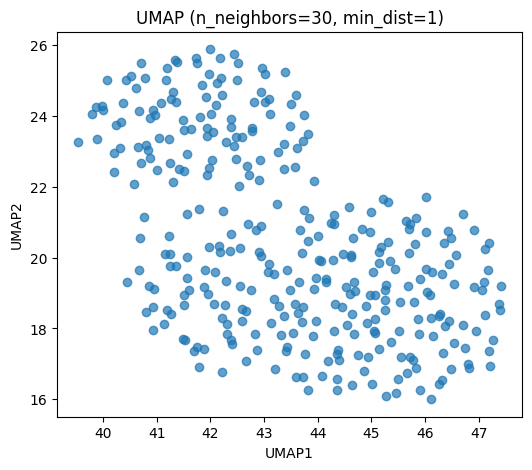

In [48]:
#differnet UMAP Hyperparameters, not used later on
umap_nn30_md1 = umap.UMAP(
    n_neighbors=30,
    min_dist=1,
    n_components=2,
    random_state=42
)

X_umap_nn30_md1 = umap_nn30_md1.fit_transform(X_umap_input)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_umap_nn30_md1[:, 0],
    X_umap_nn30_md1[:, 1],
    alpha=0.7
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP (n_neighbors=30, min_dist=1)")
plt.show()


C:\PAML\PAML Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


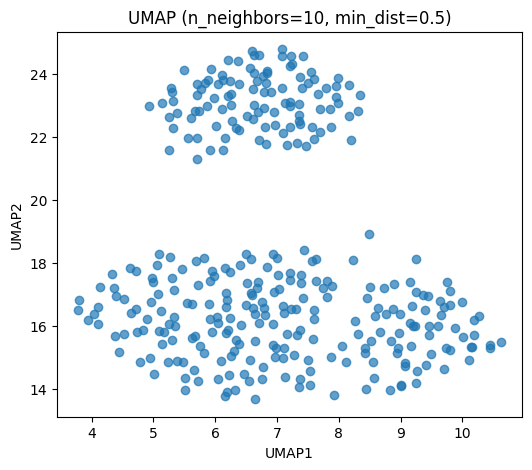

In [52]:
#differnet UMAP Hyperparameters, not used later on
umap_nn10_md05 = umap.UMAP(
    n_neighbors=10,
    min_dist=0.5,
    n_components=2,
    random_state=42
)

X_umap_nn10_md05 = umap_nn10_md05.fit_transform(X_umap_input)

plt.figure(figsize=(6, 5))
plt.scatter(
    X_umap_nn10_md05[:, 0],
    X_umap_nn10_md05[:, 1],
    alpha=0.7
)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("UMAP (n_neighbors=10, min_dist=0.5)")
plt.show()


#### ***3 tSNE*** 

In [54]:
from sklearn.manifold import TSNE

In [55]:
X_tsne_input = X_scaled


Again scaleing. tSNE ist, just as UMAP a non-linear technique. 

In [56]:
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    random_state=42,
    init="pca"
)

X_tsne = tsne.fit_transform(X_tsne_input)


Parameterwahl, in tSNE the Hyperparameter "Perplexity" determines the overall relationship of the datapoints. A high perplexity preserves a global order, while low perplexity keeps the regional relationships intact. 

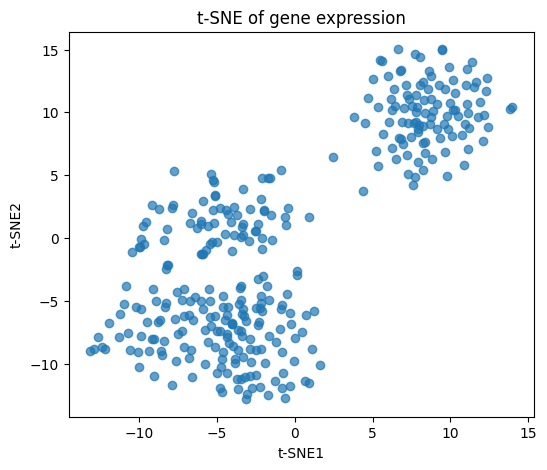

In [57]:
#tSNE one color
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(
    X_tsne[:, 0],
    X_tsne[:, 1],
    alpha=0.7
)
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE of gene expression")
plt.show()


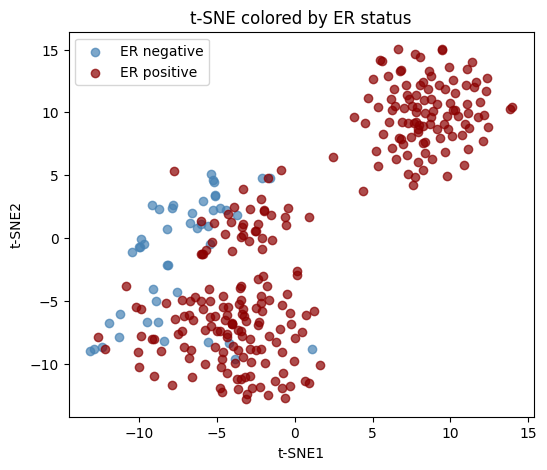

In [58]:
#tSNE colored for ER status
er_status = df_pat["er"]

plt.figure(figsize=(6, 5))

plt.scatter(
    X_tsne[er_status == 0, 0],
    X_tsne[er_status == 0, 1],
    color="steelblue",
    alpha=0.7,
    label="ER negative"
)

plt.scatter(
    X_tsne[er_status == 1, 0],
    X_tsne[er_status == 1, 1],
    color="darkred",
    alpha=0.7,
    label="ER positive"
)

plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE colored by ER status")
plt.legend()
plt.show()


In [59]:
tsne1 = X_tsne[:, 0]

print("t-SNE1 variance (ER negative):", np.var(tsne1[er_status == 0]))
print("t-SNE1 variance (ER positive):", np.var(tsne1[er_status == 1]))


t-SNE1 variance (ER negative): 9.224912
t-SNE1 variance (ER positive): 43.753334


tSNE is, just as UMAP, a non-linear technique, inheriting the same limitations to the interpretation of the plot. visible grouping is nice to observe, but close neighbourship relations are not interpretable as closeness in the dataset. It is interesting to observe three groups, compared to two groups in UMAP.

##### ***tSNE variants***

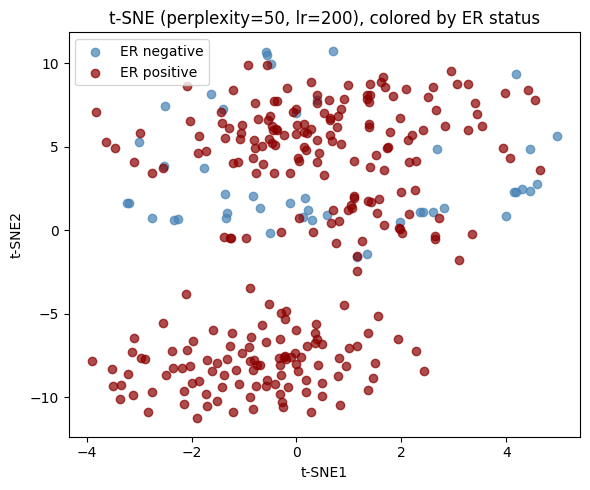

In [67]:
#tSNE Variant with other Hyperparameters
tsne_p50_lr100 = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate=100,
    random_state=42,
    init="pca"
)

X_tsne_p50_lr100 = tsne_p50_lr100.fit_transform(X_tsne_input)

plt.figure(figsize=(6, 5))

plt.scatter(
    X_tsne_p50_lr100[er_status == 0, 0],
    X_tsne_p50_lr100[er_status == 0, 1],
    color="steelblue",
    alpha=0.7,
    label="ER negative"
)

plt.scatter(
    X_tsne_p50_lr100[er_status == 1, 0],
    X_tsne_p50_lr100[er_status == 1, 1],
    color="darkred",
    alpha=0.7,
    label="ER positive"
)

plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE (perplexity=50, lr=100), colored by ER status")
plt.legend()
plt.tight_layout()
plt.show()


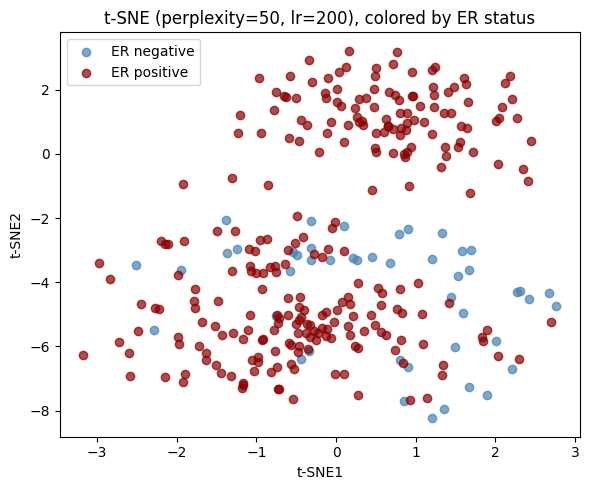

In [79]:
#tSNE Variant with other Hyperparameters
tsne_p100_lr200 = TSNE(
    n_components=2,
    perplexity=100,
    learning_rate=200,
    random_state=42,
    init="pca"
)

X_tsne_p100_lr200 = tsne_p100_lr200.fit_transform(X_tsne_input)

plt.figure(figsize=(6, 5))

plt.scatter(
    X_tsne_p100_lr200[er_status == 0, 0],
    X_tsne_p100_lr200[er_status == 0, 1],
    color="steelblue",
    alpha=0.7,
    label="ER negative"
)

plt.scatter(
    X_tsne_p100_lr200[er_status == 1, 0],
    X_tsne_p100_lr200[er_status == 1, 1],
    color="darkred",
    alpha=0.7,
    label="ER positive"
)

plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.title("t-SNE (perplexity=50, lr=200), colored by ER status")
plt.legend()
plt.tight_layout()
plt.show()


#### ***4 Comparison***

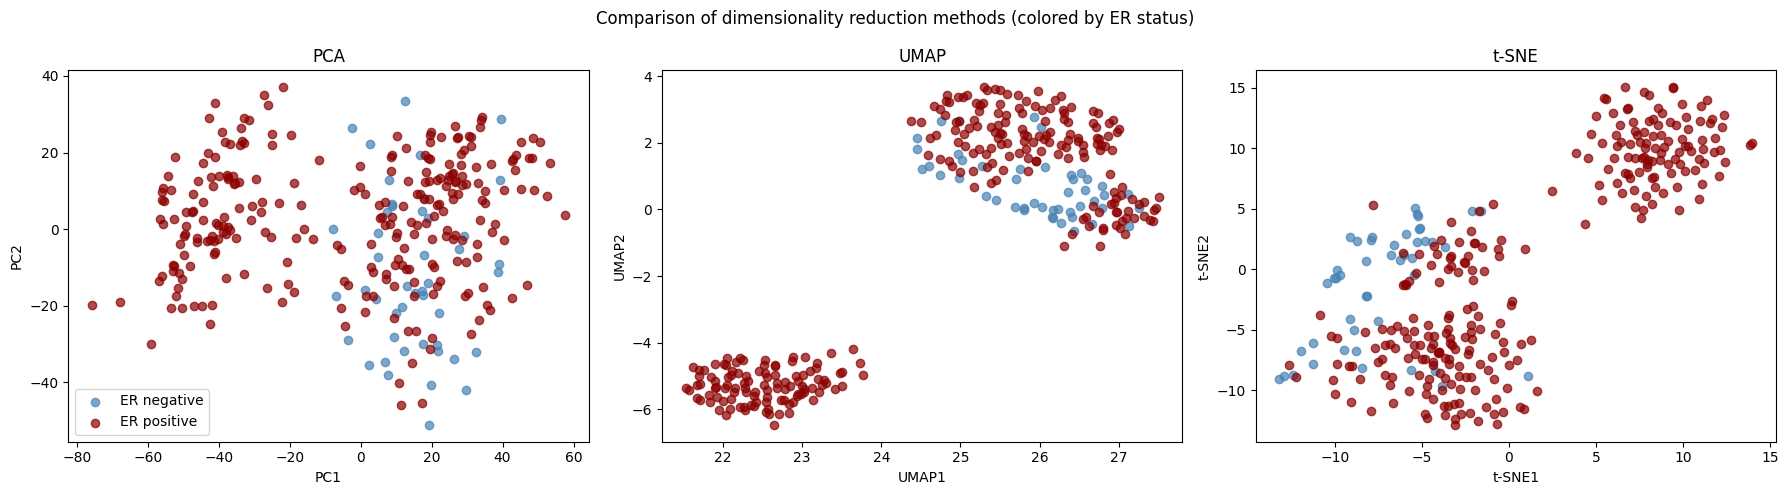

In [80]:
import matplotlib.pyplot as plt

er_status = df_pat["er"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

#PCA
#brings plots together in one layout
axes[0].scatter(
    X_pca_5[er_status == 0, 0],
    X_pca_5[er_status == 0, 1],
    color="steelblue",
    alpha=0.7,
    label="ER negative"
)
axes[0].scatter(
    X_pca_5[er_status == 1, 0],
    X_pca_5[er_status == 1, 1],
    color="darkred",
    alpha=0.7,
    label="ER positive"
)
axes[0].set_title("PCA")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend()

#UMAP VV
axes[1].scatter(
    X_umap[er_status == 0, 0],
    X_umap[er_status == 0, 1],
    color="steelblue",
    alpha=0.7
)
axes[1].scatter(
    X_umap[er_status == 1, 0],
    X_umap[er_status == 1, 1],
    color="darkred",
    alpha=0.7
)
axes[1].set_title("UMAP")
axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")

#tsne VV
axes[2].scatter(
    X_tsne[er_status == 0, 0],
    X_tsne[er_status == 0, 1],
    color="steelblue",
    alpha=0.7
)
axes[2].scatter(
    X_tsne[er_status == 1, 0],
    X_tsne[er_status == 1, 1],
    color="darkred",
    alpha=0.7
)
axes[2].set_title("t-SNE")
axes[2].set_xlabel("t-SNE1")
axes[2].set_ylabel("t-SNE2")

plt.suptitle("Comparison of dimensionality reduction methods (colored by ER status)")
plt.tight_layout()

plt.savefig(
    PROJECT_ROOT / "results" / "ComparisonDimRed.jpeg",
    dpi=600,
    bbox_inches="tight"
)

plt.show()


#### ***5 check for further suitability***

In [85]:
#calculate silhouette score for clustering ecaluation
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

mask = df_pat["er"].notna()

labels = df_pat.loc[mask, "er"].astype(int)

X_pca_5_sub = X_pca_5[mask.values, :]
X_umap_sub  = X_umap[mask.values, :]
X_tsne_sub  = X_tsne[mask.values, :]

scores = {
    "PCA (5 PCs)": silhouette_score(X_pca_5_sub, labels),
    "UMAP (2D)": silhouette_score(X_umap_sub, labels),
    "t-SNE (2D)": silhouette_score(X_tsne_sub, labels)
}

silhouette_df = pd.DataFrame.from_dict(scores, orient="index", columns=["Silhouette score"])
silhouette_df


,Silhouette score
PCA (5 PCs),0.074205
UMAP (2D),-0.089878
t-SNE (2D),0.030411


Siluette only for Pat with known ER status, NaN was excluded!

Silhouette score ranges from +1 to -1, with  highest values resemble the highest "fit" - respecting ER. PCA has the highest score, although all of the scores are clse to 0, meaning overlap and not that good seperated clusters - which can be easily seen with ER+ and ER- beeing in one cluster. 

In [83]:
#add DaviesBouldin score for cluster evaluation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

X_cluster = X_pca_5 

results = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_cluster)

    sil = silhouette_score(X_cluster, cluster_labels)
    db  = davies_bouldin_score(X_cluster, cluster_labels)

    results.append({
        "k": k,
        "Silhouette": sil,
        "Davies-Bouldin": db
    })

cluster_metrics = pd.DataFrame(results)
cluster_metrics


,k,Silhouette,Davies-Bouldin
0,2,0.401915,1.005442
1,3,0.314887,1.461158
2,4,0.311150,1.293367
3,5,0.307718,1.193336
4,6,0.243464,1.381578


Unsurprisingly, fewer clusters lead to better clustering - higher Silhouette and lower Davies-Bouldin score.

In [90]:
#linear test for downstream usability
import numpy as np

ids = df_gex["patient_id"].to_numpy()

er_map = df_pat.set_index("patient_id")["er"]
er_status = er_map.reindex(ids)  

mask = er_status.notna().to_numpy()

X_embed = X_pca_5[mask]
y_embed = er_status[mask].astype(int).to_numpy()

assert X_embed.shape[0] == y_embed.shape[0]
print("Aligned:", X_embed.shape, y_embed.shape)
print("PosRate:", y_embed.mean())


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

clf = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = cross_val_score(clf, X_embed, y_embed, cv=cv, scoring="roc_auc")
print(f"Linear probe ER | ROC-AUC: {auc_scores.mean():.3f} ± {auc_scores.std(ddof=1):.3f}")


Aligned: (308, 5) (308,)
PosRate: 0.8506493506493507
Linear probe ER | ROC-AUC: 0.935 ± 0.033


A linear probe tests for downstream useablity as required. A linear classifier was trained on the PCA5 dataset, high ROC-AUC hints, that using PCA preserves the required information, thus it is suitable to use!